In [1]:
import numpy as np
import segyio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
from scipy import signal

In [2]:
from ukpgks import segy
data = segy.read_segy('gather_38.segy',coors=False)

In [3]:
def wavelet_zerophase_1D(trace,dt,delay=1):
    # FFT forward
    fftData= np.fft.fft(trace)
    # get amplitude spectrum
    spectrum = np.abs(fftData * np.exp(-1j*2*np.pi)) 
    # take abs values and multiple to exp(-j2pi)
    # z = r(cosØ+jsinØ) <==> z = r * exp(1jØ), r abs value of z(rcosØ,rsinØ)
    # it has the effect of rotating z counterclockwise by an angle of Ø on the complex plane
    
    # contrut phase shift
    ShiftSamples = delay/dt
    N = spectrum.shape[0]
    k = np.linspace(0,N-1,N) # 0 ... N 
    shift = np.exp(-1j*2*np.pi*k*ShiftSamples/N) # Fourier tranform property, to shift multiple it with signal
    shift = np.fft.fftshift(shift)
    
    # apply shift
    spectrum = np.multiply(spectrum,shift)
    
    # get wavelet
    fftInverse = np.fft.ifft(spectrum)
    w = np.real(fftInverse)
    
    return w

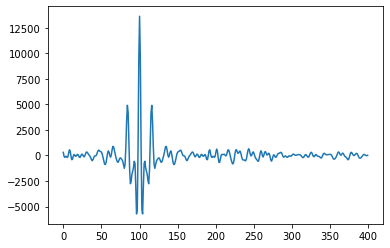

In [4]:
z = wavelet_zerophase_1D(data[600,:],0.01)
plt.plot(z[:400])

In [5]:
def wavelet_zerophase_2D(data,dt,fft_type='2D',delay=1,centered='no'):
    """
    create a zero phase wavelet usind 2D shot gather
    data [traces,time] - seismic shot gather
    fft                - fft2(data)--'2D',rfft(data,axis=1)--'1D'
    centered           - 'no' pick at 1 sec, 'yes' - pick at tmax/2
    
    Outputs:
    Dataframe with columns
    wavelet            - wavelet (np.read(inverse fft))
    time               - time array
    frequency          - freq array [0:Fnyquist], Fnyquist = 1/(2*dt)
    """
    Nt   = data.shape[1] # traces 
    time = np.linspace(0,Nt*dt,Nt) # time array
    
    # forward fft type
    if fft_type == '2D':
        fft_forward = np.fft.fft2(data)
    elif fft_type == '1D':
        fft_forward = np.fft.rfft(data,axis=1)
        spectrum = np.abs(fft_forward/(fft_forward.shape[0])) * np.exp(-1j*2*np.pi)

    # take abs values and multiples to exp(-1j*2*np.pi)
    # r abs of z(rcosØ,rsinØ), z = r(cosØ+jsinØ) <==> z = r * exp(1jØ)
    # it has the effect of rotating z counterclockwise by an angle of Ø on the complex plane
    spectrum =  np.abs(fft_forward/(fft_forward.shape[0])) * np.exp(-1j*2*np.pi)
    # sum over all traces
    spectrum = np.sum(spectrum,axis=0)

    # contrut phase shift - time shift 
    ShiftSamples = delay/dt
    N = spectrum.shape[0]
    k = np.linspace(0,N-1,N) # 0 ... N 
    shift = np.exp(-1j*2*np.pi*k*ShiftSamples/N) # Fourier transform property, to shift - multiple it with signal
    shift = np.fft.fftshift(shift)
    
    # apply shift
    spectrum = np.multiply(spectrum,shift)
    # get wavelet
    fft_inverse = np.fft.ifft(spectrum)
    
    if centered=='no':
        w = np.real(fft_inverse)
        
    elif centered=='yes':
        w = np.real(fft_inverse)
        # if W is a vector, then ifftshift swaps the left and right halves of W.
        # Inverse zero-frequency shift (ifftshift undoes the result of fftshift)
        w = np.fft.ifftshift(w)
    

    fnq = 1/(2*dt) # Nyquist freq
    freq = np.linspace(0,fnq,int(Nt))

    if fft_type == '1D':
        time = np.linspace(0,Nt*dt,int(Nt/2)+1)
        freq = np.linspace(0,fnq,int(Nt/2)+1)

    d = np.array([w,time,freq])
    df   = pd.DataFrame(data=d.T,columns=['wavelet','time','frequency'])
    return df

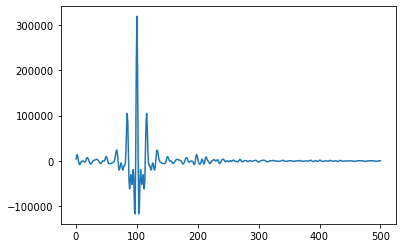

In [7]:
z = wavelet_zerophase_2D(data[:],0.01)
plt.plot(z.loc[:500,'wavelet'])